In [58]:
import pennylane as qml
from pennylane import numpy as np
from pennylane.optimize import NesterovMomentumOptimizer
from sklearn.datasets import make_blobs
import matplotlib.pyplot as plt
from pandas import DataFrame
import pandas as pd
from pennylane.templates.embeddings import AmplitudeEmbedding
from scipy.special import rel_entr
import math

Computing Expressibility-needed values

In [18]:
##### Code adapted from https://github.com/bagmk/Quantum_Machine_Learning_Express
fidelity = []
sampled_states = 2000
nshots = 1024
n_histograms = 76
N = 16

# Histogram bins
bins_list = [];
for i in range(n_histograms):
    bins_list.append((i) / (n_histograms - 1))
    
# Centers of the bins
bins_centers = []    
for i in range(n_histograms - 1):
    bins_centers.append(bins_list[1] + bins_list[i])

# Estimated distribution of Haar fidelities
# it is the integral of the Haar formula fidelity
# between the left and right values
def P_Haar(left_bin, right_bin, N):
    return (1 - left_bin)**(N - 1) - (1 - right_bin)**(N - 1)

# Haar histogram values
P_Haar_hist = []
for i in range(n_histograms - 1):
    P_Haar_hist.append(P_Haar(bins_list[i], bins_list[i+1], N))

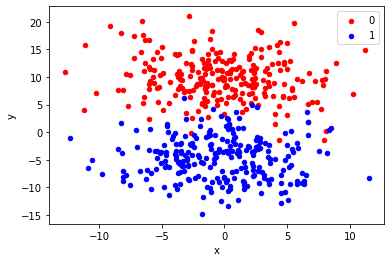

In [19]:
# generate 2d classification dataset
features, labels = make_blobs(n_samples=500, centers=2, cluster_std=4.0, n_features=16)

# scatter plot, dots colored by class value
df = DataFrame(dict(x=features[:,0], y=features[:,1], label=labels))

colors = {0:'red', 1:'blue'}
fig, ax = plt.subplots()
grouped = df.groupby('label')
for key, group in grouped:
    group.plot(ax=ax, kind='scatter', x='x', y='y', label=key, color=colors[key])
plt.show()

In [20]:
dev = qml.device("default.qubit", wires=4, shots=1024)

In [21]:
def layer(W):

    qml.Rot(W[0, 0], W[0, 1], W[0, 2], wires=0)
    qml.Rot(W[1, 0], W[1, 1], W[1, 2], wires=1)
    qml.Rot(W[2, 0], W[2, 1], W[2, 2], wires=2)
    qml.Rot(W[3, 0], W[3, 1], W[3, 2], wires=3)

    qml.CNOT(wires=[0, 1])
    qml.CNOT(wires=[1, 2])
    qml.CNOT(wires=[2, 3])
    qml.CNOT(wires=[3, 0])

In [22]:
def statepreparation(x):
    AmplitudeEmbedding(features=x, wires=[0, 1, 2, 3],normalize="True")

In [23]:
@qml.qnode(dev)
def circuit(weights, x):

    statepreparation(x)

    for W in weights:
        layer(W)

    return [qml.expval(qml.PauliZ(0)), qml.expval(qml.PauliZ(1)), qml.expval(qml.PauliZ(2)), qml.expval(qml.PauliZ(3))]
    #return qml.sample()

In [24]:
def variational_classifier(weights, bias, x):
    return circuit(weights, x) + bias

In [25]:
def square_loss(labels, predictions):
    loss = 0
    for l, p in zip(labels, predictions):
        loss = loss + (l - p) ** 2

    loss = loss / len(labels)
    return loss

In [26]:
def accuracy(labels, predictions):

    loss = 0
    for l, p in zip(labels, predictions):
        if abs(l - p) < 1e-5:
            loss = loss + 1
    loss = loss / len(labels)

    return loss

In [27]:
def cost(weights, bias, X, Y):
    predictions = [variational_classifier(weights, bias, x) for x in X]
    return square_loss(Y, predictions)

In [28]:
X = np.array(features, requires_grad=False)
Y = np.array(labels, requires_grad=False)
Y = Y * 2 - np.ones(len(Y))  # shift label from {0, 1} to {-1, 1}

#for i in range(5):
#    print("X = {}, Y = {: d}".format(X[i], int(Y[i])))
    
######

np.random.seed(0)
num_data = len(Y)
num_train = int(0.75 * num_data)
index = np.random.permutation(range(num_data))
feats_train = features[index[:num_train]]
Y_train = Y[index[:num_train]]
feats_val = features[index[num_train:]]
Y_val = Y[index[num_train:]]

# We need these later for plotting
X_train = X[index[:num_train]]
X_val = X[index[num_train:]]

In [29]:
np.random.seed(0)
num_qubits = 4
num_layers = 3
weights_init = 2 * np.pi * np.random.rand(num_layers, num_qubits, 3, requires_grad=True)
bias_init = np.array(0.0, requires_grad=True)

print(weights_init, bias_init)

[[[3.44829694 4.49366732 3.78727399]
  [3.42360201 2.66190161 4.0582724 ]
  [2.74944154 5.60317502 6.0548717 ]
  [2.40923412 4.97455513 3.32314479]]

 [[3.56912924 5.8156952  0.44633272]
  [0.54744954 0.12703594 5.23150478]
  [4.88930306 5.46644755 6.14884039]
  [5.02126135 2.89956035 4.90420945]]

 [[0.74314013 4.02074236 0.90071527]
  [5.93552986 3.27886971 2.60539781]
  [1.66225193 4.86465374 2.86607707]
  [3.57157584 0.1180598  3.88071828]]] 0.0


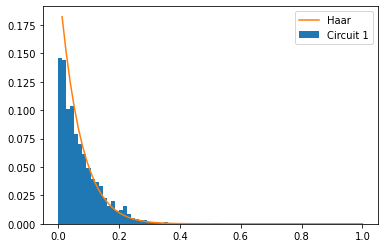

KL(P || Q): 0.031 nats


In [14]:
##### More code adapted from https://github.com/bagmk/Quantum_Machine_Learning_Express
x = X_train[0]
for state in range(sampled_states):
    weights_init = np.random.randn(num_layers, num_qubits, 3, requires_grad=True)
    result = variational_classifier(weights_init, bias_init, x)
    result_strings = ["".join(map(str, [int(res[0]), int(res[1]), int(res[2]), int(res[3])])) for res in result.numpy()]
    ratio = result_strings.count("0000") / nshots
    fidelity.append(ratio)

weights = np.ones_like(fidelity)/float(len(fidelity))
plt.hist(fidelity, bins=bins_list, weights=weights, range=[0, 1], label='Circuit 1')
plt.plot(bins_centers, P_Haar_hist, label='Haar')
plt.legend(loc='upper right')
plt.show()

# example of calculating the kl divergence (relative entropy) with scipy
P_1_hist = np.histogram(fidelity, bins=bins_list, weights=weights, range=[0, 1])[0]
kl_pq = rel_entr(P_1_hist, P_Haar_hist)
print('KL(P || Q): %.3f nats' % sum(kl_pq))

Let's do the Entanglement capability

In [94]:
def to_string(qubit):
    my_list = list(qubit.numpy())
    #print("list", my_list)
    return ''.join(str(elem) for elem in my_list)

def D_distance(vec_1, vec_2):
    #print(vec_1)
    #print(vec_2)
    assert len(vec_1) == len(vec_2)
    d = 0
    for i in range(len(vec_1)):
        for j in range(len(vec_2)):
            d = d + abs(vec_1[i]*vec_2[j] - vec_1[j]*vec_2[i])**2
    return d / 2

def get_coeff_idx(qubit):
    #print("[to become int] qubit is : ", qubit)
    #print(int(to_string(qubit), 2))
    return int(to_string(qubit), 2)

def i_func(i, j, psi, n):
    final_coeffs = np.zeros(2**n)
    
    for qubit_idx in range(n):
        base_qubit = [0] * qubit_idx + [1] + [0] * (n - qubit_idx - 1)
        #print(base_qubit)
        #print(f"i:{i}, j:{j}")
        
        array_qubit_removed = np.delete(base_qubit, j)
        
        coeff_idx = get_coeff_idx(array_qubit_removed)
        
        if base_qubit[j] != i:
            final_coeffs[coeff_idx] = 0
        else:
            #print("will retain coeff")
            final_coeffs[coeff_idx] = psi[qubit_idx]

    return final_coeffs

sampled_states = 1
def Q_entanglement():
    x = X_train[0]
    for state_idx in range(sampled_states):
        print(state_idx)
        weights_init = np.random.randn(num_layers, num_qubits, 3, requires_grad=True)
        result = variational_classifier(weights_init, bias_init, x)
        Q = 0
        n = 4 # log2(N)
        for res in result:
            q = 0
            for j in range(n):
                i0 = i_func(0, j, res)
                i1 = i_func(1, j, res)
                #print(i0, i1)
                q = q + D_distance(i0, i1)
            q = q * 4 / n
            Q = Q + q
        print("Entanglement so far: ", Q / (state_idx+1))
    return Q / sampled_states

"""
n = 4
q_01 = 0
res = np.array([0,0,1,0])
print(res)
for j in range(n):
    i0 = i_func_hehe(0, j, res)
    i1 = i_func_hehe(1, j, res)
    #print(i0, i1)
q_01 = q_01 + D_distance(i0, i1)
q_01 = q_01 * 4 / n
print(q_01)
"""

"""
n = 2 # number of qubits
q_01 = 0
psi_test = np.array([1/math.sqrt(2),0,0,0])#-1/math.sqrt(2)])
print(psi_test)
# I work on vectorised qubits
N = 2**n #dim of Hilbert space
for j in range(N): 
    #print("j is ", j)
    i0 = i_func(0, j, psi_test, N)
    i1 = i_func(1, j, psi_test, N)
    #print("final i0, final i1")
    #print(i0, i1)
    d = D_distance(i0, i1)
    q_01 = q_01 + d
    print(d)
    print("####")
q_01 = q_01 * 4 / n
print(q_01)
"""


n = 3 # number of qubits
q_01 = 0
psi_test = np.array([1/math.sqrt(2),0,0,0,0,0,0,1/math.sqrt(2)])
print(len(psi_test))
# I work on vectorised qubits
N = 2**n #dim of Hilbert space
for j in range(N): 
    #print("j is ", j)
    i0 = i_func(0, j, psi_test, N)
    i1 = i_func(1, j, psi_test, N)
    #print("final i0, final i1")
    #print(i0, i1)
    d = D_distance(i0, i1)
    q_01 = q_01 + d
    print(d)
    print("####")
q_01 = q_01 * 4 / n
print(q_01)

8
0.2499999999999999
####
0.0
####
0.0
####
0.0
####
0.0
####
0.0
####
0.0
####
0.2499999999999999
####
0.6666666666666664


In [16]:
# Taken from Pennylane tutorial
opt = NesterovMomentumOptimizer(0.1)
batch_size = 5

weights = weights_init
bias = bias_init

history_train = []
history_validation = []
epochs = 35

for it in range(epochs):

    # Update the weights by one optimizer step
    batch_index = np.random.randint(0, num_train, (batch_size,))
    X_train_batch = X_train[batch_index]
    Y_train_batch = Y_train[batch_index]
    weights, bias, _, _ = opt.step(cost, weights, bias, X_train_batch, Y_train_batch)

    # Compute predictions on train and validation set
    predictions_train = [np.sign(variational_classifier(weights, bias, f)) for f in X_train]
    predictions_val = [np.sign(variational_classifier(weights, bias, f)) for f in X_val]
    
    if it == epochs - 1:
    
        df1 = DataFrame(dict(x=X_val[:,0], y=X_val[:,1], label=Y_val))
        colors1 = {-1:'red', 1:'blue'}
        fig, ax = plt.subplots()
        grouped = df1.groupby('label')
        for key, group in grouped:
            group.plot(ax=ax, kind='scatter', x='x', y='y', label=key, color=colors1[key], s=50, alpha=0.5)
        #plt.plot()


        df2 = DataFrame(dict(x=X_val[:,0].numpy(), y=X_val[:,1].numpy(), label=predictions_val))
        colors2 = {-1:'orange', 1:'green'}
        fig, ax = plt.subplots()
        grouped2 = df2.groupby('label')
        for key, group in grouped2:
            key = key.numpy()
            group.plot(ax=ax, kind='scatter', x='x', y='y', label=key, color=colors2[key], s=50, alpha=0.5)
        plt.plot()

        #result = pd.merge(df1, df2,  how='left', left_on=['x','y'], right_on = ['x','y'])
    
        #print(result.head)

    # Compute accuracy on train and validation set
    acc_train = accuracy(Y_train, predictions_train)
    acc_val = accuracy(Y_val, predictions_val)
    
    history_train.append(acc_train)
    history_validation.append(acc_val)

    print(
        "Iter: {:5d} | Cost: {:0.7f} | Acc train: {:0.7f} | Acc validation: {:0.7f} "
        "".format(it + 1, cost(weights, bias, features, Y), acc_train, acc_val)
    )

TypeError: Grad only applies to real scalar-output functions. Try jacobian, elementwise_grad or holomorphic_grad.

In [ ]:
df2 = DataFrame(dict(x=X_val[:,0].numpy(), y=X_val[:,1].numpy(), label=predictions_val))
colors2 = {-1:'orange', 1:'green'}
fig, ax = plt.subplots()
grouped2 = df2.groupby('label')
for key, group in grouped2:
    key = key.numpy()
    group.plot(ax=ax, kind='scatter', x='x', y='y', label=key, color=colors2[key], s=50, alpha=0.5)
plt.plot()

In [ ]:
plt.plot(history_train)
plt.plot(history_validation)
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

In [97]:
def my_quantum_function():
    qml.Hadamard(wires=0)
    qml.CNOT(wires=[0, 1])
    return qml.probs(wires=[0, 1])

dev = qml.device("default.qubit", wires=2)
qnode = qml.QNode(my_quantum_function, dev)
qnode()

tensor([0.5, 0. , 0. , 0.5], requires_grad=True)